In [42]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [43]:
sdg_indexes = pd.read_csv("data/sdg_prediction/sdg_indexes.csv")
sat_mod = pd.read_csv("data/sdg_prediction/sat_mod.csv")
sdg_indicators = pd.read_csv("data/sdg_prediction/sdg_indicators_norm.csv")

sat_mod = sat_mod.join(pd.get_dummies(sat_mod.dep))


## Setting up model 

In [44]:
sat_mod.columns

Index(['Unnamed: 0', 'id', 'dep', 'lnEGDPpc2012', 'lnagr_land2012',
       'lnurb_land2012', 'ln_perUrb_land2012', 'ln_tr400_pop2012',
       'ln_pm25_2012', 'ln_land_temp2012', 'ln_t400NTLpc2012',
       'ln_dist_road2017', 'ln_ghsl2015', 'dist_diamond2015',
       'ln_mal_inci_rt_mean', 'ln_dist_water2017mean', 'ln_elev2017mean',
       'ln_dist_drug2017mean', 'photov2019mean', 'access2016mean',
       'ln_access2016mean', 'slope500m2017mean', 'ln_slope500m2017mean',
       'Beni', 'Chuquisaca', 'Cochabamba', 'La Paz', 'Oruro', 'Pando',
       'Potosí', 'Santa Cruz', 'Tarija'],
      dtype='object')

In [71]:
X = sat_mod[['ln_ghsl2015', 'lnagr_land2012', 'lnurb_land2012','ln_land_temp2012', 'ln_tr400_pop2012', 'ln_dist_road2017',
             'ln_dist_drug2017mean', 'ln_pm25_2012', 'photov2019mean', 'Beni', 'Chuquisaca', 'Cochabamba', 'La Paz',
       'Oruro', 'Pando', 'Potosí', 'Santa Cruz', 'Tarija']]

#X = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land2012',  "ln_pm25_2012", "ln_land_temp2012"]]

#X = sat_mod[['ln_t400NTLpc2012', "ln_perUrb_land2012", 'ln_land_temp2012','ln_tr400_pop2012','ln_dist_road2017','ln_ghsl2015', 
#             "ln_dist_water2017mean",'ln_dist_drug2017mean', 'ln_elev2017mean', 'ln_pm25_2012', 'photov2019mean', 
#             'lnagr_land2012', 'lnurb_land2012','ln_access2016mean']]
  #'dist_diamond2015',   'lnagr_land2012', 'lnurb_land2012',
    # Elevation has a huge impact on 2 and 13 
y = sdg_indexes["imds"]

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = linear_model.Ridge()
model.fit(X_train, y_train);

print(f"Non CV score: {model.score(X_test, y_test).round(2)}\n")

coeff = model.coef_
print("Relevant and positive:")
print(np.array(X.columns)[coeff>1])
print("\nRelevant and negative:")
print(np.array(X.columns)[coeff<-1])
print("\n")
print(model.coef_)


Non CV score: 0.69

Relevant and positive:
['ln_ghsl2015' 'lnagr_land2012' 'lnurb_land2012' 'Oruro' 'Santa Cruz'
 'Tarija']

Relevant and negative:
['ln_tr400_pop2012' 'ln_dist_road2017' 'ln_dist_drug2017mean'
 'ln_pm25_2012' 'photov2019mean' 'Chuquisaca' 'Cochabamba' 'Pando']


[ 4.87165097  1.38722959  5.92857296 -0.41150904 -5.17731708 -1.0882697
 -1.19776355 -3.58410758 -1.25696668 -0.90753412 -3.00551881 -2.08314548
  0.82085264  1.600254   -2.44984407 -0.89502863  1.21102773  5.70893674]


## Test for all labels 

In [67]:
ridge_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])
ri_predict = pd.DataFrame()

In [68]:
y_variables = sdg_indexes[['index_sdg1', 'index_sdg2', 'index_sdg3', 'index_sdg4',
       'index_sdg5', 'index_sdg6', 'index_sdg7', 'index_sdg8', 'index_sdg9',
       'index_sdg10', 'index_sdg11', 'index_sdg13', 'index_sdg15',
       'index_sdg16', 'index_sdg17', 'imds']]

#y_variables = sdg_indicators.drop(columns = {"id"})

In [69]:
#x = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land2012',  
#               "ln_pm25_2012", "ln_land_temp2012",'ln_dist_road2017' ,'ln_ghsl2015']]
# This ones make some sdg more relevant 
#
x = X

for y_variable in y_variables:
    
    y = y_variables[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3) 
    ridge_model_it = linear_model.Ridge()

    r2 = np.mean(cross_val_score(ridge_model_it, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(ridge_model_it, x, y, scoring="neg_mean_absolute_error"))
    
    ridge_results.loc[len(ridge_results.index)] = [y_variable, r2, mae]

    # Prediction df 
    ridge_model_it.fit(x_train,y_train)
    y_pred = ridge_model_it.predict(x_test)

    col0 = y_variable + "_true"
    col1 = y_variable + "_pred"
    temp_predict = pd.DataFrame({col0: y_test, col1: y_pred}, index=y_test.index)
    temp_predict.index.name = "id"
    
    if ri_predict.empty:
        ri_predict = temp_predict
    else:
        ri_predict = ri_predict.merge(temp_predict, on="id", how="outer")

In [70]:
ridge_results[ridge_results["r2"]>0 ].round(4).sort_values(by="r2", ascending=False)

,Feature,r2,MAE
0,index_sdg1,0.6222,-9.9819
10,index_sdg11,0.5798,-5.9983
8,index_sdg9,0.5767,-7.8120
15,imds,0.5688,-3.4695
6,index_sdg7,0.5289,-8.0484
11,index_sdg13,0.4390,-7.6586
7,index_sdg8,0.4283,-6.0543
5,index_sdg6,0.4094,-9.5302
9,index_sdg10,0.3578,-9.0009
1,index_sdg2,0.3515,-6.8348


In [50]:
ridge_results[ridge_results["r2"]<0].round(4)

,Feature,r2,MAE
12,index_sdg15,-0.1844,-13.4851
13,index_sdg16,-0.0137,-7.3630


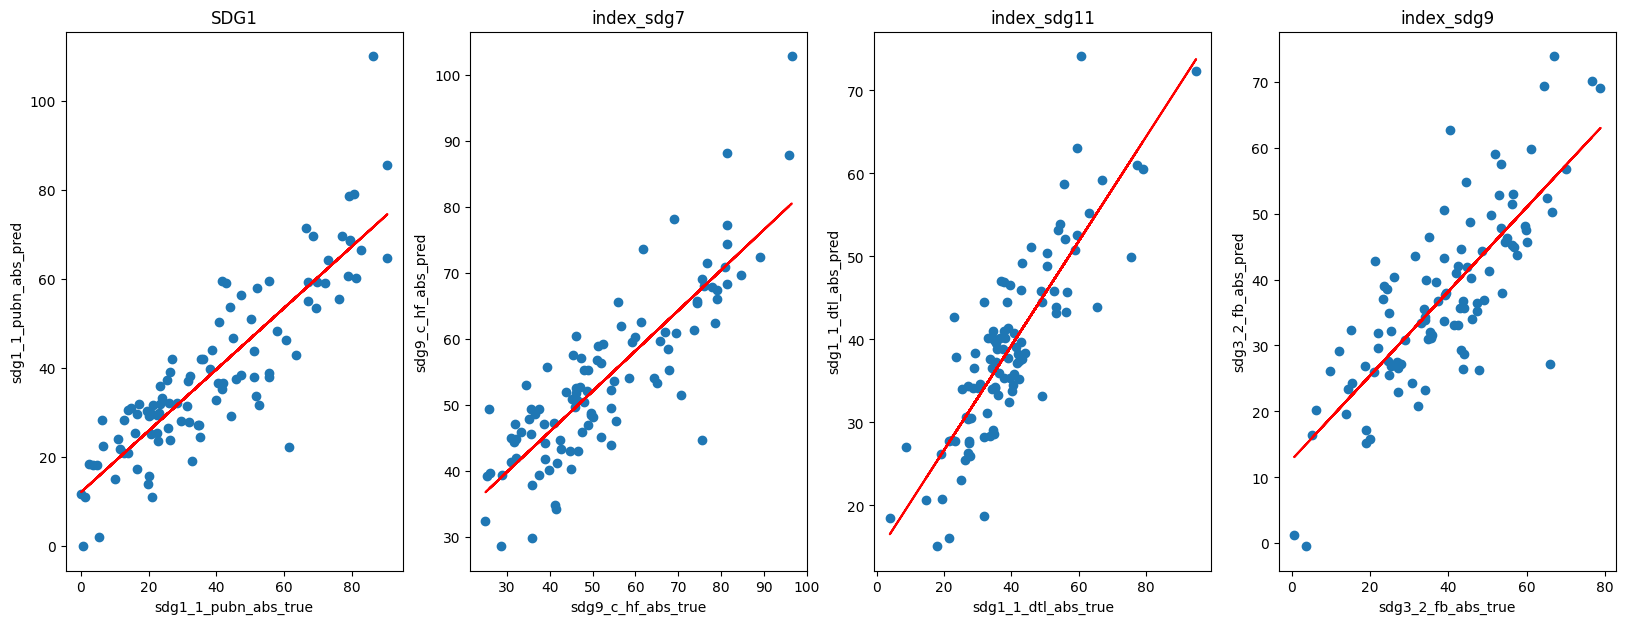

In [51]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, 
                                         ncols=4, 
                                         figsize=(20, 7))

# Graph 1 
g_x = ri_predict["index_sdg1_true"]
g_y = ri_predict["index_sdg1_pred"]

ax0.scatter(x = g_x, y = g_y)
ax0.set(xlabel="sdg1_1_pubn_abs_true", ylabel="sdg1_1_pubn_abs_pred", title="SDG1")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax0.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg7_true"]
g_y = ri_predict["index_sdg7_pred"]

ax1.scatter(x = g_x, y = g_y)
ax1.set(xlabel="sdg9_c_hf_abs_true", ylabel="sdg9_c_hf_abs_pred", title="index_sdg7")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax1.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg11_true"]
g_y = ri_predict["index_sdg11_pred"]

ax2.scatter(x = g_x, y = g_y)
ax2.set(xlabel="sdg1_1_dtl_abs_true", ylabel="sdg1_1_dtl_abs_pred", title="index_sdg11")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax2.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg9_true"]
g_y = ri_predict["index_sdg9_pred"]

ax3.scatter(x = g_x, y = g_y)
ax3.set(xlabel="sdg3_2_fb_abs_true", ylabel="sdg3_2_fb_abs_pred", title="index_sdg9")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax3.plot(g_x,p(g_x),"r-")

# Adjust Hyperparameters

In [52]:
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [53]:
model_tuned = linear_model.Ridge(alpha=0.0001, max_iter=1000)
model_tuned.fit(X_train, y_train);
model.score(X_test, y_test)


0.6911207719390412

In [54]:
alpha_space = np.logspace(-4,0,30)
alpha_space

ridge_scores = []
ridge_pipeline = make_pipeline(StandardScaler(), Ridge())

for alpha in alpha_space: 
    ridge_pipeline.alpha = alpha
    val = np.mean(cross_val_score(ridge_pipeline, X, y, cv = 10))
    ridge_scores.append(val)

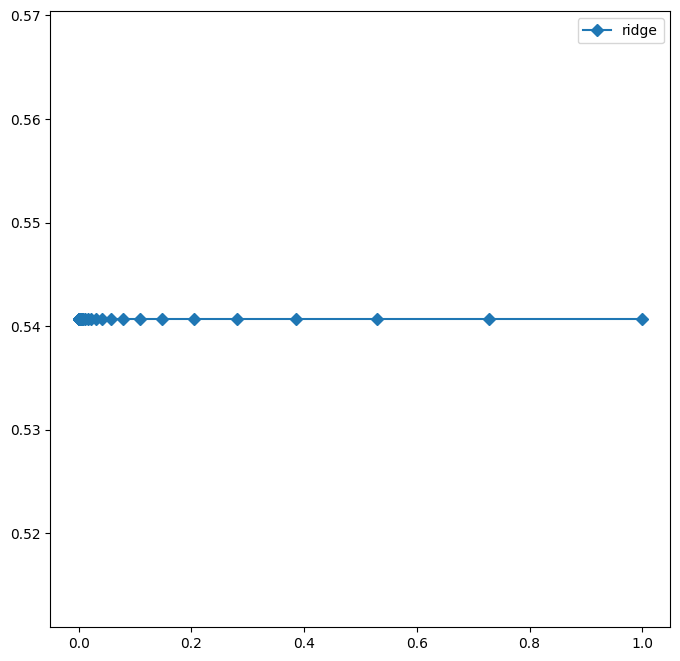

In [55]:
plt.figure(figsize=(8,8))
plt.plot(alpha_space, ridge_scores, marker="D", label = "ridge")
plt.legend()
plt.show()

In [56]:
def evaluate_preds(model, y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    r2 = np.mean(cross_val_score(model, X, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, X, y, scoring="neg_mean_absolute_error"))
    metric_dict = {"R2": round(r2, 2),
                   "MAE": round(mae, 2)}
    print(f"R2: {r2 * 100:.2f}%")
    print(f"MAE: {mae:.2f}")
    
    return metric_dict

In [57]:
grid = {"alpha": alpha_space,
        "copy_X": [True, False],
        "max_iter": [None, 10, 100, 200, 500, 1000, 10000], 
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]}

np.random.seed(42)
rs_rid_model= RandomizedSearchCV(estimator = model,
                                 param_distributions=grid,
                                 n_iter=100,
                                 cv=5,
                                 verbose=0)

rs_rid_model.fit(X_train, y_train);

In [58]:
rs_rid_model.best_params_

{'solver': 'cholesky', 'max_iter': 10, 'copy_X': False, 'alpha': 1.0}

In [59]:
# Uses the best model for the prediction
rs_y_preds = rs_rid_model.predict(X_test)

rs_metrics = evaluate_preds(rs_rid_model, X, y)

KeyboardInterrupt: 